# Exploratory Data Analysis

In [5]:
import pandas as pd
import numpy as np
import altair as alt
%matplotlib inline
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.plotly as py
import seaborn as sns

In [11]:
df = pd.read_json('/data/danield2255/tidy_music.json')
song_popularity = pd.read_json('/data/danield2255/song_popularity.json')
song_year = pd.read_json('/data/danield2255/song_year.json')
song_genres = pd.read_json('/data/danield2255/song_genres.json')
song_tempo = pd.read_json('/data/danield2255/song_tempo.json')
song_mode = pd.read_json('/data/danield2255/song_mode.json')
song_key = pd.read_json('/data/danield2255/song_key.json')
song_length = pd.read_json('/data/danield2255/song_length.json')
genre_loudness = pd.read_json('/data/danield2255/genre_loudness.json')
genre_mode = pd.read_json('/data/danield2255/genre_mode.json')
songpop_artistpop = pd.read_json('/data/danield2255/songpop_artistpop.json')

ValueError: Expected object or value

### "What genres of music are most popular?"

In [10]:
df['genre'].value_counts()

NameError: name 'df' is not defined

In looking at the value counts, it is apparant that there are 458 genre categories, with many of these genres even just a single observation. To explore what genres are most popular, we will subset this table to only contain genres with 30 or more observations, as a sample of 30 in statistics is generally acceptable. 

In [4]:
genre_popularity= song_popularity.merge(song_genres, on = 'song_id')
genre_popularity = genre_popularity.groupby('genre').filter(lambda x: len(x) >= 30)
print(genre_popularity['genre'].value_counts())
print(genre_popularity.count())

blues-rock             346
hip hop                346
ccm                    255
chanson                208
country rock           156
latin jazz             150
post-grunge            146
dance pop              141
gangster rap           134
roots reggae           131
pop rock               130
progressive house      119
heavy metal             97
dancehall               97
power pop               94
rock                    92
chill-out               90
salsa                   82
jazz funk               80
hardcore punk           79
lovers rock             76
country gospel          75
honky tonk              73
post-hardcore           72
irish folk              70
folk-pop                69
alternative metal       67
dance rock              67
soundtrack              65
country blues           65
                      ... 
chamber jazz            41
europop                 39
brazilian pop music     39
zydeco                  38
dubstep                 38
cumbia                  38
g

We now have observations from 98 genres, 6616 observations total, and this should be a bit more appropriate to compare statistics on. 

In [5]:
genre_avg_popularity = genre_popularity.groupby('genre')['song_hotness'].mean()
genre_avg_popularity= genre_avg_popularity.sort_values(ascending=False).to_frame()
genre_avg_popularity = pd.DataFrame(genre_avg_popularity.reset_index())

In [3]:
graph = genre_avg_popularity.head(100).plot(kind='bar', figsize = (20, 5), title = 'Average Song Hotness by Genre')
graph.set_xticklabels(genre_avg_popularity['genre'].values[0:100])
graph.set_xlabel('Genre')
graph.set_ylabel('Average Song Hotness')


NameError: name 'genre_avg_popularity' is not defined

The visualization reveals that among the genres with the greatest average song hotness include alternative metal, post-hardcore, and grunge. Meanwhile some less popular genres include opera, pop folk, and cantonese pop.

### "What genres have been most popular over time, and what genres have become popular in the modern era?"

Because what is currently popular is always changing, it is likely a good idea to look at popular genres over time. We will also exclude observations with no recorded release year for this, as well as years with less than 10 observations and less than 5 observations in each genre for that year. 

In [8]:
gpop_by_year = song_popularity.merge(song_year, on = 'song_id').merge(song_genres, on = 'song_id')
gpop_by_year = gpop_by_year.dropna()
gpop_by_year = gpop_by_year.groupby('release_year').filter(lambda x: len(x) >= 10)
gpop_by_year =gpop_by_year.groupby(['release_year', 'genre']).filter(lambda x: len(x) >= 5)
gpop_by_year = gpop_by_year.groupby(['release_year', 'genre'])['song_hotness'].mean().unstack()
plt.figure(figsize = (16,15))
fig = sns.heatmap(gpop_by_year.transpose(), cmap = 'YlGnBu', cbar_kws={'label': 'Average Song Hotness'}, linecolor = 'black', linewidths=0.9)
fig.set(xlabel='Release Year', ylabel='Genre', title = 'Average Song Hotness for Various Genres By Year')

NameError: name 'song_popularity' is not defined

The information conveyed in the heatmap makes intuitive sense as it is easy to justify the popularity of various genres in different eras. Blues rock has had steady popularity from the 1970's through to current day. As music became more and more commercialized with the onset of MTV, file sharing formats, and the internet, pop and dance oriented music gained popularity . Also after the grunge movement, genres like post grunge and post-hardcore helped dominate the rock scene. Finally, various rap genres and hip-hop moved into the mainstream in the late 1990's and early 2000's due to the creation of more and more advanced synthesizers and the maturing nature of hip-hop as a genre.

**NOTE**: It is important to remember here that as time went on, more and more music was produced which may explain why there is greater representation of data from the 90's and 2000's. Also this data was a subset of 10,000 songs from a million song dataset, so it is very possible the sample simply pulled more data from this era. 

### "Is song length associated with song popularity?"

In [8]:
length_popularity = song_popularity.merge(song_length, on = 'song_id')
length_popularity.describe()

,song_hotness,duration
count,10000.000000,10000.000000
mean,0.193626,240.622038
std,0.251809,246.084090
min,0.000000,1.044440
25%,0.000000,176.032200
50%,0.000000,223.059140
75%,0.405116,276.375060
max,1.000000,22050.000000


The summary indicated a significantly greater outlier for duration, so it is removed in the next step.

In [9]:
length_popularity= length_popularity.loc[length_popularity.duration < 5000]

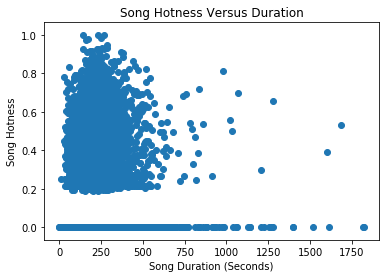

In [10]:
plt.scatter('duration', 'song_hotness', data = length_popularity)
plt.xlabel('Song Duration (Seconds)')
plt.ylabel('Song Hotness')
plt.title('Song Hotness Versus Duration')
plt.show()

The visualization reveals that song duration alone does not have an extremely strong relationship with song hotness. However, the observations with the highest song hotness have durations of around 250 seconds long, and this makes intuitive sense as most songs on the radio, which get more publicity, are around this length of just over 4 minutes. 

### "What are the most popular song keys and modes?"

The dataset classifies major or minor tonality of a song in the 'mode' variable. The following blocks of code split the data into separate datasets by mode, then measures the average song popularity rating for songs in each musical key. 

In [11]:
key_mode_pop = song_popularity.merge(song_key, on = 'song_id').merge(song_mode, on = 'song_id')

In [12]:
key_pop_major = key_mode_pop.loc[key_mode_pop['mode'] == 'Major']
key_pop_minor = key_mode_pop.loc[key_mode_pop['mode'] == 'Minor']

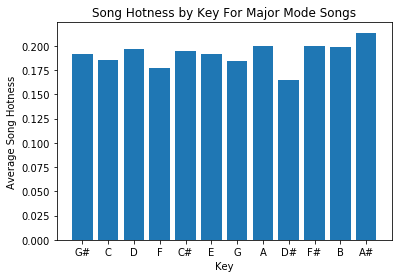

In [13]:
x_axis = key_pop_major['key'].unique()
temp = np.arange(len(x_axis))
y_axis = key_pop_major.groupby('key')['song_hotness'].mean()
plt.bar(temp, y_axis)
plt.xticks(temp, x_axis)
plt.xlabel('Key')
plt.ylabel('Average Song Hotness')
plt.title('Song Hotness by Key For Major Mode Songs')
plt.show()

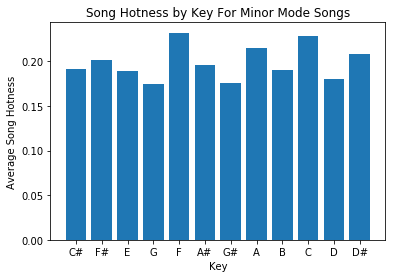

In [14]:
key_pop_minor = key_pop_minor[key_pop_minor.key != 904.80281]
#There was a invalid key value in the minor subset of data that needed to be removed
x_axis2 = key_pop_minor['key'].unique()
temp2 = np.arange(len(x_axis2))
y_axis2 = key_pop_minor.groupby('key')['song_hotness'].mean()
alt.Chart()
plt.bar(temp2, y_axis2)
plt.xticks(temp2, x_axis2)
plt.xlabel('Key')
plt.ylabel('Average Song Hotness')
plt.title('Song Hotness by Key For Minor Mode Songs')
plt.show()

In major modes, average song hotness by key suggests the most popular key is A#, but it is worth noting that there is very little variation between the keys. It appears that in the minor mode the most popular keys according to average song hotness are F and C. Also there is more variation in the average popularity of songs between musical keys in the minor mode than in the major mode.

### "What are the most popular tempos for songs?"

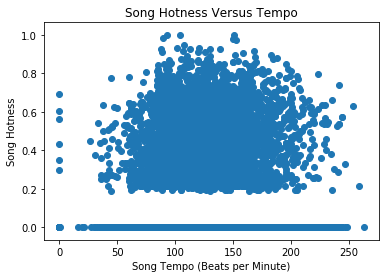

In [15]:
tempo_pop = song_popularity.merge(song_tempo, on = 'song_id')
plt.scatter('tempo', 'song_hotness', data = tempo_pop)
plt.xlabel('Song Tempo (Beats per Minute)')
plt.ylabel('Song Hotness')
plt.title('Song Hotness Versus Tempo')
plt.show()

The plot of song hotness versus tempo does not really establish a strong correlation between the two, suggesting that songs from a wide range of tempos have the potential to be popular. The most popular songs in the dataset however, are between 90 and 150 beats per minute.

### "Does loudness vary between genres?"

In [16]:
genre_loudness = genre_loudness.groupby('genre').filter(lambda x: len(x) >= 30)
genre_loudness = genre_loudness.groupby('genre')['loudness'].mean().reset_index()

In [17]:
alt.Chart(genre_loudness).mark_line().encode(
alt.X('genre', axis = alt.Axis(title="Genre"),sort=alt.SortField(field = 'loudness', op='sum', order= 'descending')), 
alt.Y('loudness', axis = alt.Axis(title="Average Peak Decibel Level (dbfs)")))

<VegaLite 2 object>

The above visualization measures the average peak decibel level for each genre. Peak decibel is measured on a negative scale with 0 as a maximum.

There is a clear difference in loudness betweeen genres, and it makes intuitive sense. Genres like black metal, alternative metal, and post-hardcore among other similar intense genres have the highest average peak decibel levels. Meanwhile opera, soundtrack, chamber jazz, and other softer genres have the lower peak decibel levels. While this does not directly predict song popularity, it suggests that different genres are associated with varying loudness. 

### "Is an artist's popularity related to song popularity?"

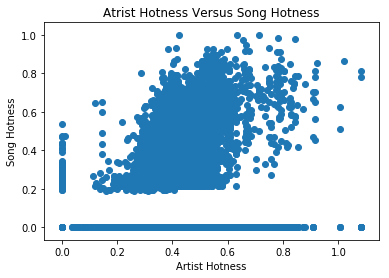

In [18]:
lin_params = np.polyfit(songpop_artistpop['artist_hotness'], songpop_artistpop['song_hotness'], deg = 1)
slope=lin_params[0]
lin_intercept=lin_params[1]
fig, ax = plt.subplots()
ax.scatter('artist_hotness', 'song_hotness', data=songpop_artistpop)
ax.plot(x=songpop_artistpop['artist_hotness'], y=(slope*songpop_artistpop['song_hotness'] + lin_intercept))
plt.xlabel('Artist Hotness')
plt.ylabel('Song Hotness')
plt.title('Atrist Hotness Versus Song Hotness')
plt.show()

The plot of artist hotness versus song hotness shows a potential positive correlation. This also makes intuitive sense as a popular artist will generally get greater exposure, thus have a higher likelihood of their songs gaining popularity. 